<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Mohammad Ali Olama
### Student Number : 98100497
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


In [4]:
df['class_label'].value_counts()

2    3315
1     537
3     317
0     289
Name: class_label, dtype: int64

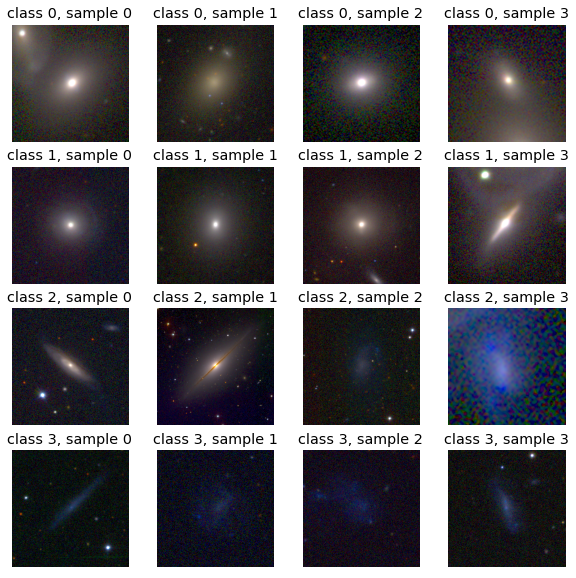

In [5]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################


fig = plt.figure(figsize=(10,10))
for i in range(4):    
    new_df = df[df.class_label==i]
    name_list = list(new_df["name"])
    for j in range(4):
        s = name_list[j]
        address = './efigi-1.6/png/'+s+'.png'
        img = plt.imread(address)
        img_grid = fig.add_subplot(4, 4, (i)*4+j+1 , xticks=[], yticks=[])
        img_grid.imshow(img)
        img_grid.set_title('class ' + str(i)+", sample " +str(j))

plt.show()

# Define Dataset (20 Points)

In [6]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self , pd , img_folder , transform):
        self.base_dataset = pd
        self.transform=transform
        self.img_folder=img_folder
        pass

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self , index):
        target = self.base_dataset.iloc[index , 2]
        s = self.base_dataset.iloc[index, 0]
        image=cv2.imread(self.img_folder+ s + '.png')
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
        image=self.transform(image)
            
        return image , target
        pass

In [7]:
from sklearn.model_selection import train_test_split

train_val, test_dataset = train_test_split(df, test_size=0.3)
train_dataset , valid_dataset = train_test_split(train_val , test_size = 0.3)


In [8]:
train_dataset = GalaxyDataSet(train_dataset, './efigi-1.6/png/' , transforms.ToTensor())
valid_dataset = GalaxyDataSet(valid_dataset,'./efigi-1.6/png/', transforms.ToTensor())
test_dataset  = GalaxyDataSet(test_dataset ,'./efigi-1.6/png/', transforms.ToTensor())

In [9]:
num_threads = 5     
batch_size  = 100  

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                # <-- this reshuffles the data at every epoch
                                          num_workers=num_threads)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 2184 images, in 22 batches
The validation set contains 936 images, in 10 batches
The test set contains 1338 images, in 14 batches


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


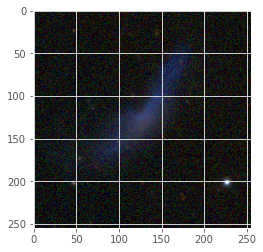

In [10]:
image , target = test_dataset[3]
plt.imshow(  image.permute(1, 2, 0)  )

# Define Model (20 Points)

In [11]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):

    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.classifier =  nn.Sequential(
            *linear_relu(input_size, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        return y

# Train Model (30 Points)

In [12]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

model=ClassifierModel(3*255*255, 4)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()


def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################


# The next 2 functions are copied from exercise 2

def update_confusion_matrix(conf_matrix, preds, reals):
    for i in range(len(preds)):
        t = preds[i]
        s = reals[i]
        conf_matrix[t][s] +=1
        
    return conf_matrix


def f1_score(confusion_matrix):
    epsilon = 1e-7
    row_sum = np.sum(confusion_matrix , axis=1)
    per_class_precision_matrix = confusion_matrix.diagonal() / (row_sum + epsilon)
    
    col_sum = np.sum(confusion_matrix , axis=0)
    
    per_class_recall_matrix = confusion_matrix.diagonal() / (col_sum + epsilon)
    
    per_class_f1_score = (2*per_class_precision_matrix*per_class_recall_matrix) / (per_class_recall_matrix + per_class_precision_matrix + epsilon)
    f1_scor = np.mean(per_class_f1_score)
    
    return f1_scor # , per_class_precision_matrix , per_class_recall_matrix , per_class_f1_score


def test(model, loader, f_loss, device):

    with torch.no_grad():
        
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        confusion = np.zeros((4, 4))
        for i, (inputs, targets) in enumerate(loader):

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            N += inputs.shape[0]

            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
            confusion = update_confusion_matrix(confusion , predicted_targets.cpu().detach().numpy(), targets.cpu().detach().numpy())
        f1 = f1_score(confusion)
        return tot_loss/N, correct/N , f1



import os
last_path = None
def generate_unique_logpath(logdir, raw_run_name):
    i = 0
    while(True):
        run_name = raw_run_name + "_" + str(i)
        log_path = os.path.join(logdir, run_name)
        if not os.path.isdir(log_path):
            os.mkdir(log_path)
            last_path = log_path
            return log_path
        i = i + 1

class ModelCheckpoint:

    def __init__(self, filepath, model):
        self.max_f1 = None
        self.filepath = filepath
        self.model = model

    def update(self, f1):
        if (self.max_f1 is None) or (f1 > self.max_f1):
            print("Saving a better model at " , self.filepath)
            torch.save(self.model.state_dict(), self.filepath)
            self.max_f1 = f1

top_logdir = "./Logs"
if not os.path.exists(top_logdir):
    os.mkdir(top_logdir)
logdir = generate_unique_logpath(top_logdir, "fully")
model_checkpoint = ModelCheckpoint(logdir + "/best_model.pt", model)





In [13]:
epochs = 30
FC1 = []
FC2 = []
FC_val_f1 = []
FC3 = []
FC4 = []
FC_train_f1 = []
for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc , val_f1 = test(model, valid_loader, f_loss, device)
    train_loss, train_acc , train_f1 = test(model, train_loader, f_loss, device)
    FC1.append(val_loss)
    FC2.append(val_acc)
    FC_val_f1.append(val_f1)
    FC3.append(train_loss)
    FC4.append(train_f1)
    FC_train_f1.append(train_f1)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}, f1 : {:.4f}".format(train_loss, train_acc , train_f1))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}, f1 : {:.4f}".format(val_loss, val_acc , val_f1))
    model_checkpoint.update(val_f1)

Epoch 0
 Training : Loss : 0.7595, Acc : 0.7486, f1 : 0.2753
 Validation : Loss : 0.7987, Acc : 0.7532, f1 : 0.2518
Saving a better model at  ./Logs/fully_24/best_model.pt
Epoch 1
 Training : Loss : 0.6631, Acc : 0.7843, f1 : 0.3747
 Validation : Loss : 0.7429, Acc : 0.7479, f1 : 0.3128
Saving a better model at  ./Logs/fully_24/best_model.pt
Epoch 2
 Training : Loss : 0.5028, Acc : 0.8274, f1 : 0.5412
 Validation : Loss : 0.6444, Acc : 0.7639, f1 : 0.3443
Saving a better model at  ./Logs/fully_24/best_model.pt
Epoch 3
 Training : Loss : 0.4168, Acc : 0.8924, f1 : 0.7891
 Validation : Loss : 0.6207, Acc : 0.7746, f1 : 0.4207
Saving a better model at  ./Logs/fully_24/best_model.pt
Epoch 4
 Training : Loss : 0.3460, Acc : 0.8942, f1 : 0.6695
 Validation : Loss : 0.6124, Acc : 0.7703, f1 : 0.4034
Epoch 5
 Training : Loss : 0.3021, Acc : 0.8915, f1 : 0.6312
 Validation : Loss : 0.6557, Acc : 0.7650, f1 : 0.3053
Epoch 6
 Training : Loss : 0.2337, Acc : 0.9451, f1 : 0.8940
 Validation : Loss 

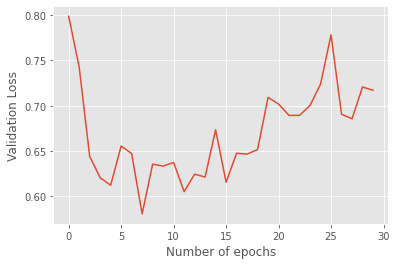

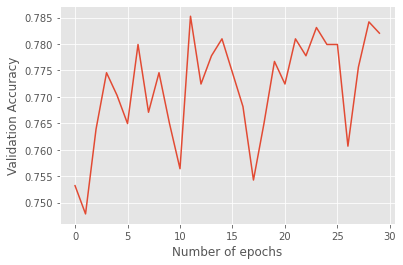

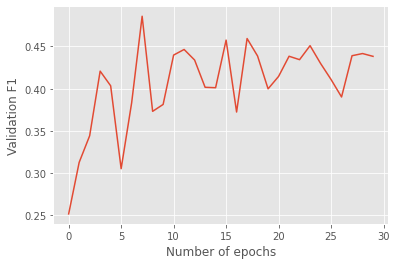

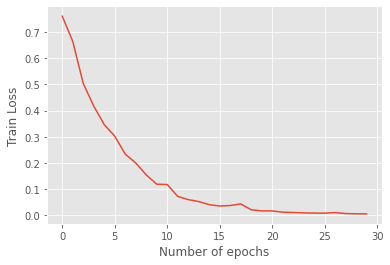

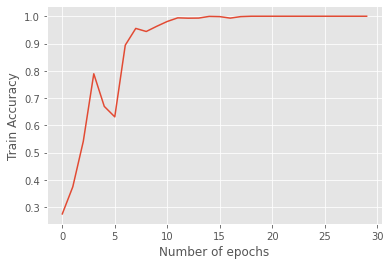

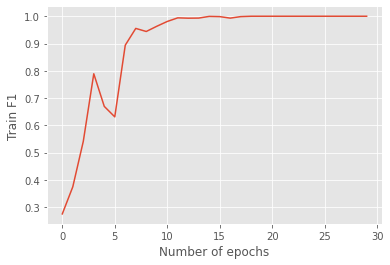

In [14]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
import seaborn as sns

plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC1))
plt.xlabel("Number of epochs")
plt.ylabel("Validation Loss")
plt.show()


plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC2))
plt.xlabel("Number of epochs")
plt.ylabel("Validation Accuracy")
plt.show()

plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC_val_f1))
plt.xlabel("Number of epochs")
plt.ylabel("Validation F1")
plt.show()


plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC3))
plt.xlabel("Number of epochs")
plt.ylabel("Train Loss")
plt.show()


plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC4))
plt.xlabel("Number of epochs")
plt.ylabel("Train Accuracy")
plt.show()


plt.figure()
ax = sns.lineplot(x=list(range(epochs)), y=list(FC_train_f1))
plt.xlabel("Number of epochs")
plt.ylabel("Train F1")
plt.show()

# Test Model (20)

In [15]:
model_path =  logdir + '/best_model.pt'
model=ClassifierModel(3*255*255, 4)

model = model.to(device)

model.load_state_dict(torch.load(model_path))

model.eval()

test_loss, test_acc , test_f1 = test(model, test_loader, f_loss, device)
print(" Test  : F1-Score: {:.4f} ,  Loss : {:.4f}, Acc : {:.4f}, ".format(test_f1 ,test_loss, test_acc ))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 Test  : F1-Score: 0.5283 ,  Loss : 0.6205, Acc : 0.7608, 
